In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack


# Load dataset

In [2]:
headers = ['text','id', 'subreddit', 'meta', 'time', 'author', 'ups', 'downs', 'authorlinkkarma', 'authorkarma', 'authorisgold']
# reddit.columns = headers

In [3]:
reddit = pd.read_csv('comments.csv', names= headers, date_parser=['time'])  # header=None

In [4]:
reddit.shape

(2726000, 11)

# Preprocess

In [5]:
reddit.isnull().sum()

text               184261
id                      0
subreddit               0
meta                    0
time                15814
author              15814
ups                 15814
downs               15814
authorlinkkarma       253
authorkarma           253
authorisgold        35410
dtype: int64

In [6]:
# delete comments with NaN text
reddit = reddit[reddit['text'].notna()]

A lot of comments are there but the text are deleted. We should get rid of those records as well:

In [7]:
reddit[reddit.authorisgold.isna()][:10]

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold
39,[ deleted ],d028eod,worldnews,news,1.455651e+09,[deleted],-1.0,0.0,0.0,0.0,NaN
252,[ removed ],d02cx5w,worldnews,news,1.455657e+09,[deleted],1.0,0.0,0.0,0.0,NaN
264,those pundits do n't have eighth time .,d02okk5,politics,news,1.455674e+09,1blah1,1.0,0.0,0.0,0.0,NaN
265,people think trump is an idiot. they are wrong...,d02kj5o,politics,news,1.455668e+09,ntt2wtt,1.0,0.0,0.0,0.0,NaN
266,make no mistake. donald trump knows exactly wh...,d02k5ou,politics,news,1.455667e+09,fuckingoff,1.0,0.0,0.0,0.0,NaN
403,[ deleted ],d02brz5,worldnews,news,1.455655e+09,[deleted],0.0,0.0,0.0,0.0,NaN
411,[ deleted ],d024aa7,politics,news,1.455645e+09,[deleted],1.0,0.0,0.0,0.0,NaN
420,[ deleted ],d01xwhf,worldnews,news,1.455636e+09,[deleted],16.0,0.0,0.0,0.0,NaN
430,[ deleted ],d01nnv6,worldnews,news,1.455605e+09,[deleted],-65.0,0.0,0.0,0.0,NaN
441,[ deleted ],d022qbv,politics,news,1.455643e+09,[deleted],1.0,0.0,0.0,0.0,NaN


In [8]:
reddit = reddit[reddit.text.str.find('[deleted]')!= False]

Some other comments have non-void text but the text is actually empty. We should also get rid of them.

In [9]:
reddit = reddit[reddit.text.str.len() != 0]

In [10]:
# drop duplicates -- turns out that there are a lot of duplicated rows
reddit = reddit.drop_duplicates()

In [11]:
# NAs in authorlinkkarma and authorkarma are annoying duplicates! --> should simply delete them
reddit = reddit[reddit.authorlinkkarma.isna() == False]

In [12]:
# fill NA's in author is gold with 0
reddit['authorisgold'].fillna(0, inplace=True)

# EDA

In [13]:
reddit.describe()

,time,ups,downs,authorlinkkarma,authorkarma,authorisgold
count,9.792100e+04,97921.000000,97921.0,9.792100e+04,9.792100e+04,97921.000000
mean,1.455394e+09,53.915646,0.0,5.128443e+03,1.755740e+04,0.081382
std,1.731153e+06,264.824208,0.0,6.021745e+04,6.161786e+04,0.273422
min,1.400891e+09,-164.000000,0.0,0.000000e+00,-1.000000e+02,0.000000
25%,1.455559e+09,1.000000,0.0,1.000000e+00,3.280000e+02,0.000000
50%,1.455629e+09,4.000000,0.0,1.060000e+02,2.913000e+03,0.000000
75%,1.455656e+09,16.000000,0.0,1.476000e+03,1.347400e+04,0.000000
max,1.455688e+09,6453.000000,0.0,5.650077e+06,2.220594e+06,1.000000


In [14]:
reddit.downs.unique()

array([0.])

### A few initial observations about the data:
* No comments have any downvotes. --> This feature could be excluded. 
* Most authors are not gold users.
* 'Gaming' is the topic that users seem to be most actively posting comments. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

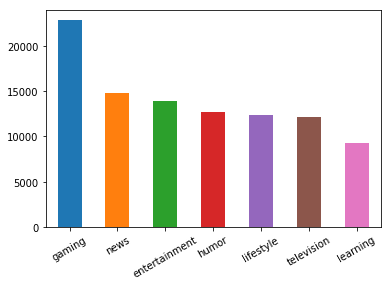

In [15]:
reddit.meta.value_counts().plot.bar()
plt.xticks(rotation=30)

Most comments receive up to 1000 upvotes. There are a number of comments that receive an extreme high number of upvotes (more than 5000). However, the interval between 1000 and 5000 upvotes is almost deserted. For the sake of generalization, we will focus on the majority of comments which are those that receive less than 1000 upvotes.

/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


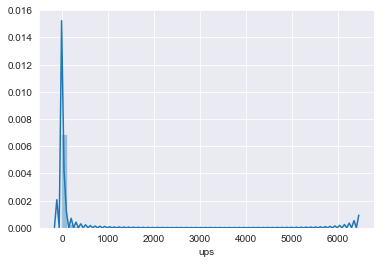

In [16]:
sns.set_style('darkgrid')
sns.distplot(reddit['ups'])

In [17]:
reddit = reddit[reddit['ups'] <= 1000]

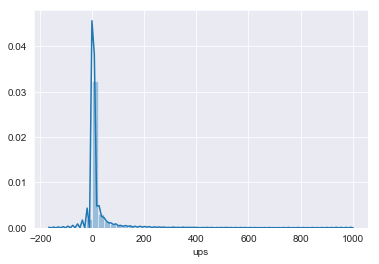

In [18]:
sns.set_style('darkgrid')
sns.distplot(reddit['ups'])

A closer look shows that looking at comments receiving less than 200 upvotes should be an even more reasonable choice.

__Question__. What's strange is that there are negative number of upvotes. Why so?

In [19]:
reddit = reddit[reddit['ups'] <= 200]

# Feature engineering

### Number of links in the comment

In [20]:
reddit['num_link'] = reddit['text'].str.count('http') + reddit['text'].str.count('https')

In [21]:
# Now remove all the links out of the text


In [22]:
# # p_link = re.compile("https? : //([\w_-]+(?:(?:\.[\w_-]+)+)([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-]*))?")
# p_link = re.compile('(https? : \/\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)+\/?\s?')


In [23]:
# text = "easonable : http : //www.nytimes.com/1987/11/12/us/reagan-nominates-anthony-kennedy-to-supreme-court.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process http : //imgur.com/pbeveod"
# result = p_link.findall(text)
# print(result)

In [24]:
# for element in result[0]:
#     text = text.replace(element, '')
# text

In [25]:
# text.replace(':','')
# text

### Word count

In [26]:
# remove punctuations
reddit.text = reddit.text.str.replace('[.,?!;:]', '')

In [27]:
reddit['word_count'] = reddit['text'].str.split().str.len()

In [47]:
# After removing comments of more than 200 upvotes, very lengthy comments are already removed
# reddit.word_count.max()

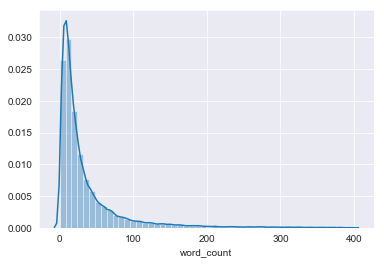

In [48]:
sns.distplot(reddit['word_count'])
# plt.hist(x=reddit['word_count'], bins=10000)

__Note__: Most comments seem to have less than 400 words but there are some dubiously long comments. --> Outliers to remove. Will treat them separately. --> No need to worry about anymore. After removing those comments that receive more than 200 upvotes, the outliers in terms of word count are removed as a by-product.

In [30]:
# reddit_long = reddit[reddit.word_count >= 400]
# reddit = reddit[reddit.word_count < 400]

### Word count categorical
Based on this distribution, we'll discretize comments based on word count into 4 groups: short, medium, long, and very long comments.

In [50]:
bins=[-1, 25, 50, 100, 500]
reddit['word_count_cat'] = pd.cut(reddit['word_count'], bins, labels=['short', 'medium', 'long', 'very long'])

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

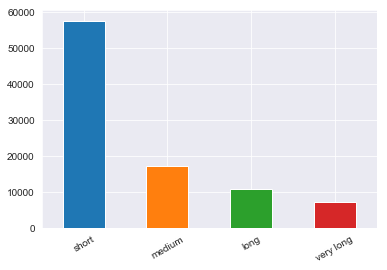

In [51]:
reddit.word_count_cat.value_counts().plot.bar()
plt.xticks(rotation=30)

### Subjectivity

In [34]:
# number of times the user uses 'I' in the comment
reddit['subjectivity'] = reddit['text'].str.count('i ')

__Question__: Why are weird duplicates that `drop_duplicates` couldn't get rid of?

In [35]:
# reddit = reddit.drop_duplicates()

In [52]:
reddit[reddit.subjectivity == 32]  # why same comment but 4 records of different numbers of upvotes?

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold,num_link,word_count,word_count_cat,subjectivity
415682,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,32.0,0.0,0.566,0.566,0.0,0,351,very long,32
472125,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,33.0,0.0,0.566,0.566,0.0,0,351,very long,32
574945,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,35.0,0.0,0.566,0.566,0.0,0,351,very long,32
649423,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,31.0,0.0,0.566,0.566,0.0,0,351,very long,32


/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


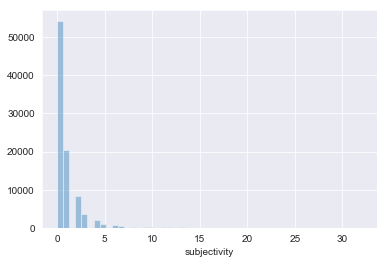

In [54]:
sns.distplot(reddit.subjectivity, kde=False)

### Number of unique words

# Numericalize and normalize data

In [76]:
all_col = set(reddit.columns)
print(all_col) 
print(f"\nNumber of columns in the dataframe: {len(all_col)}")

{'author', 'word_count_cat', 'subreddit', 'text', 'ups', 'authorlinkkarma', 'downs', 'word_count', 'authorkarma', 'id', 'subjectivity', 'authorisgold', 'time', 'meta', 'num_link'}

Number of columns in the dataframe: 15


In [81]:
# Categorical variables
# _variables = ['subreddit','meta', 'time', 'author', 
#                  'authorlinkkarma', 'authorkarma', 'authorisgold', 'word_count_cat']

# Excluded variables
excluded_variables = ['id', 'author', 'ups', 'downs', 'text']  # ups is the response variable, downs is trivial
                                                               # text is for separate td-idf transformation 
len(excluded_variables)

5

In [82]:
# Numerical variables
inde_variables = list(all_col.difference(set(excluded_variables)))
inde_variables

['word_count_cat',
 'subreddit',
 'authorlinkkarma',
 'word_count',
 'authorkarma',
 'subjectivity',
 'authorisgold',
 'time',
 'meta',
 'num_link']

### Normalize karma

`authorlinkkarma` and `authorkarma` are very large values, more than allowed for dtype('float64') --> We will normalize these 2 columns by dividing by 1000.

In [43]:
reddit['authorkarma'] = reddit['authorlinkkarma']/1000
reddit['authorlinkkarma'] = reddit['authorlinkkarma']/1000

### Vectorize `text`

In [83]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(reddit['text'])

### Numericalize categorical variables

In [86]:
encoder = DictVectorizer()
X_inde = encoder.fit_transform(reddit[inde_variables].to_dict('records'))

# Model fitting

In [88]:
y = reddit.ups
x = hstack([X_tfidf, X_inde])
# x = hstack([X_tfidf, X_categ, reddit[num_variables]])

### Split into a test set and a training set

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Linear Regression

In [90]:
lm_model = LinearRegression()

In [91]:
lm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [94]:
y_predicted = lm_model.predict(X_test)

In [95]:
mse = mean_squared_error(y_test, y_predicted)
print(f"{mse:.4}")

954.1


Text(0.5, 1.0, 'Redisual plot')

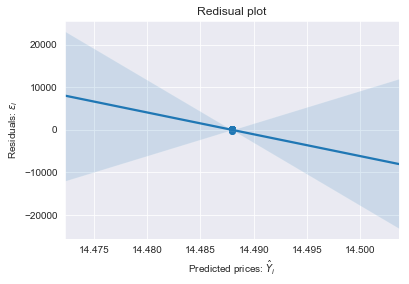

In [97]:
# Why there are no dots
ax = sns.regplot(y_predicted, y_test - y_predicted);
ax.set_xlabel("Predicted prices: $\hat{Y}_i$")
ax.set_ylabel("Residuals: $\epsilon_i$")
ax.set_title("Redisual plot")

In [98]:
from sklearn.metrics import r2_score

In [99]:
r2_score(y_pred=y_predicted, y_true=y_test)

-4.7267523727967387e-05

$R^2$ is terrible! Is something wrong here.